In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML
import warnings

from optimizers import SGD, Adagrad, Adadelta, RMSProp, Adam, AdaMax 

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.ffmpeg_path'] = "/usr/bin/ffmpeg"
warnings.simplefilter('ignore')

In [3]:
from functions import Beale
from function_configs import BEALE_CONFIG
from animations import TrajectoryAnimation, TrajectoryAnimation3D

In [4]:
def optimize(func, grad_func, optimizer, initial, n_iter=100000, epsilon=1e-6):

    params = initial
    opt_path = []
    old_loss = 0.0
    
    for it in range(n_iter):
        
        loss = func(*params)
        
        if np.abs(loss - old_loss) <= epsilon:
            print("stopped")
            break

        opt_path.append(params)
        grad_params = grad_func(*params)
        params = optimizer.step(params, grad_params)
        old_loss = loss
        
    return params, np.array(opt_path)

In [6]:
function = Beale(**BEALE_CONFIG)

xmin, xmax, xstep = BEALE_CONFIG['xmin'], BEALE_CONFIG['xmax'], BEALE_CONFIG['step']
ymin, ymax, ystep = BEALE_CONFIG['xmin'], BEALE_CONFIG['ymax'], BEALE_CONFIG['step']

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = function(x, y)

In [7]:
all_optimizers = [
    SGD(lr=1e-2),
    Adagrad(lr=1e-2),
    Adadelta(lr=1e-2),
    RMSProp(lr=1e-2),
    Adam(lr=1e-2),
    AdaMax(lr=1e-2)
]

all_end_values = []
all_opt_paths = []

for optimizer in all_optimizers:
    initial = np.array(BEALE_CONFIG['initial'])
    end_values, opt_path = optimize(function, function.grad, optimizer, initial)
    all_end_values.append(end_values)
    all_opt_paths.append(opt_path)

stopped
stopped
stopped
stopped


In [8]:
def sample_path(path, total_sample=100):
    
    path_len = len(path)
    
    if path_len < total_sample * 2:
        indices = np.sort(np.random.choice(path_len, total_sample, replace=False))
        return path[indices]
    
    increment = path_len//total_sample    

    return np.vstack((path[::increment], path[-1]))

In [9]:
methods = ['SGD', 'Adagrad', 'Adadelta', 'RMSProp', 'Adam', 'AdaMax']
[len(path) for path in all_opt_paths]

[100000, 100000, 10275, 847, 16070, 10512]

In [10]:
total_sample = 200
sampled_paths = [path if len(path) < total_sample else sample_path(path, total_sample=total_sample) 
                 for path in all_opt_paths]

In [11]:
[len(path) for path in sampled_paths]

[201, 201, 203, 213, 202, 204]

In [12]:
sampled_paths = [path.T for path in sampled_paths]
zpaths = [function(*path) for path in sampled_paths]

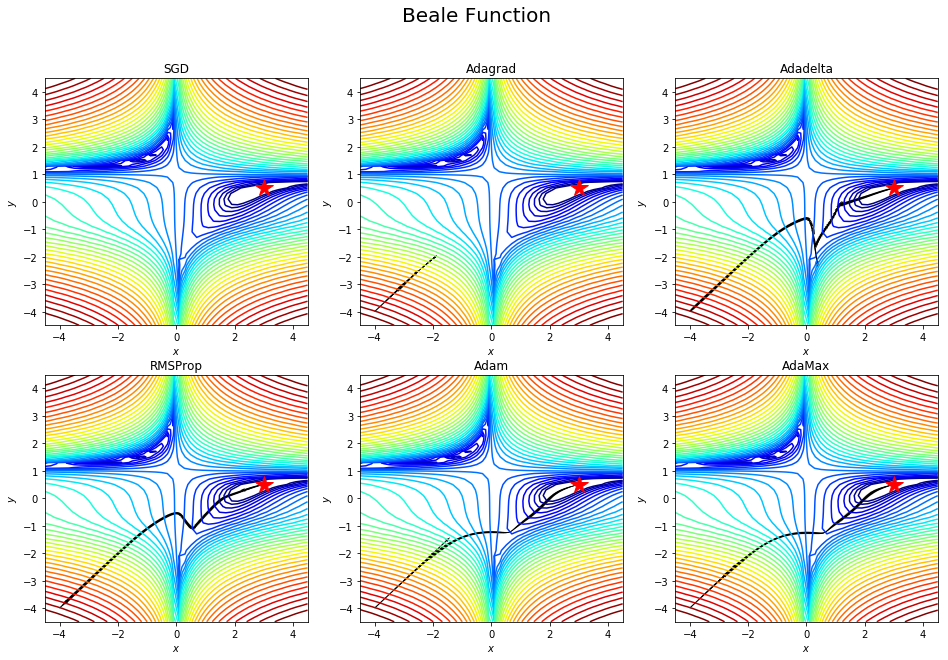

In [13]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Beale Function', fontsize=20)

for i, (method, path) in enumerate(zip(methods, sampled_paths)):
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
              scale_units='xy', angles='xy', scale=0.25) 
    ax.plot(function.minima[:, 0], function.minima[:, 1], 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_title(method)
    
plt.savefig('beale_2d.png')

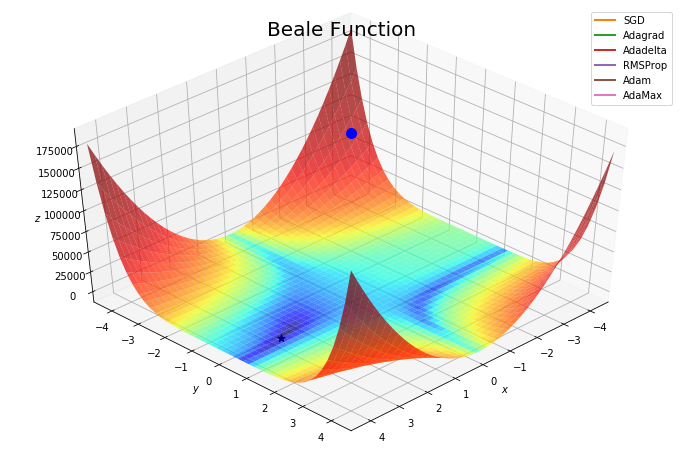

In [16]:
fig = plt.figure(figsize=(12, 8))

ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, edgecolor='none', norm=LogNorm(),
                alpha=0.7, cmap=plt.cm.jet, zorder=0)

ax.scatter3D(function.minima[:, 0], function.minima[:, 1], 
        function(function.minima[:, 0], function.minima[:, 1]).reshape(-1, 1), 
             c='black', marker='*', s=60, zorder=5)

ax.plot(*np.array(initial).reshape(-1, 1), function(*initial), c='b', 
        marker='o', markersize=10, zorder=5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.set_title("Beale Function", fontdict={"fontsize": 20})
ax.view_init(elev=45, azim=45)

anim = TrajectoryAnimation3D(*sampled_paths, zpaths=zpaths, labels=methods, fig=fig, ax=ax)

ax.legend(loc='upper right')

In [17]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('beale_3d_animation.mp4', fps=60)